# Project Topic:
This project uses Supervised Machine Learning via Support Vector Machine (SVM) to conduct a Binary Classification on the Cleveland Clinic Heart Disease Dataset. The goal is to build a highly accurate and reliable model to predict the presence of heart disease in patients.
# Data
The data was donladed from UCI Machine Learning Repository.
Janosi, A., Steinbrunn, W., Pfisterer, M., & Detrano, R. (1989). Heart Disease [Dataset]. UCI Machine Learning Repository. https://doi.org/10.24432/C52P4X.
The datset contains 303 samples with 13 features given below:

| Variable Name | Type | Missing Values |
| :--- | :--- | :--- |
| **age** | Integer | no |
| **sex** | Categorical | no |
| **cp** | Categorical | no |
| **trestbps** | Integer | no |
| **chol** | Integer | no |
| **fbs** | Categorical | no |
| **restecg** | Categorical | no |
| **thalach** | Integer | no |
| **exang** | Categorical | no |
| **oldpeak** | Integer | no |
| **slope** | Categorical | no |
| **ca** | Integer | yes |
| **thal** | Categorical | yes |
| **num** | Integer | no |

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.svm import SVC
import seaborn as sns
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
%matplotlib inline

In [ ]:
import pandas as pd
import numpy as np

file_path = 'processed_cleveland.csv' 
# dsv file contains the dataset

df = pd.read_csv(file_path)
header = list(df.columns.values)
print(df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    object 
 12  thal      303 non-null    object 
 13  num       303 non-null    int64  
dtypes: float64(1), int64(11), object(2)
memory usage: 33.3+ KB
None


# Data Cleaning
First, I change the name of the target feature from 'num' to 'HeartDisease' and save that as y, then I drop those clomuns to get the train data.

Next, I split the train and test data with a 25% test size with stratify for this imbalanced dataset.

There are two features that have missing values which are stored as '?', To clean the data I have converet the '?' values into NAN. I then use a Simple Imputer that replaces the NAN with the median. 

For the Categorical features I use One Hot encoder, and for the integer features I use a standard scaler then concatenate the features.

In [ ]:
# Changes target variable name in dataframe
df['HeartDisease'] = df['num'].apply(lambda x: 1 if x >= 1 else 0) 
y = df[['HeartDisease']] 
X = df.drop(columns=['HeartDisease', 'num'], axis=1)

# split dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size = 0.25,
    random_state = 137, 
    stratify = y
)

# reshape the variables to avoid warnings
fy_train = y_train.values.ravel()
fy_test = y_test.values.ravel()

# colmuns with missing values stored as '?'
imputationCol = ['thal','ca']

# replace ? with NAN
X_train[imputationCol] = X_train[imputationCol].replace('?', np.nan)
X_test[imputationCol] = X_test[imputationCol].replace('?', np.nan)

# convert back to numeric values
X_train['ca'] = pd.to_numeric(X_train['ca'])
X_train['thal'] = pd.to_numeric(X_train['thal'])
X_test['ca'] = pd.to_numeric(X_test['ca'])
X_test['thal'] = pd.to_numeric(X_test['thal'])

# impute the missing data by replacing with median
imputer = SimpleImputer(strategy='median')
imputer.fit(X_train[imputationCol])
X_train[imputationCol] = imputer.transform(X_train[imputationCol])
X_test[imputationCol] = imputer.transform(X_test[imputationCol])

In [ ]:
oneHotEncodeCol = ['cp','restecg','slope','thal']
scalarCol = ['age', 'sex', 'trestbps', 'chol', 'fbs', 'thalach', 'exang', 'oldpeak', 'ca']

# one hot encoder for categoricl features
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoder.fit(X_train[oneHotEncodeCol])

# renamed encoded X_train and X_test
eX_train = encoder.transform(X_train[oneHotEncodeCol])
eX_test = encoder.transform(X_test[oneHotEncodeCol])
featureNames = encoder.get_feature_names_out(oneHotEncodeCol)

#updated the names of columns for the encoded features
eX_train = pd.DataFrame(eX_train, columns=featureNames, index=X_train.index)
eX_test = pd.DataFrame(eX_test, columns=featureNames, index=X_test.index)

In [ ]:
# scalar for the interger features 
scaler = StandardScaler()
scaler.fit(X_train[scalarCol])

# renamed the scaled X_train and X_test
sX_train = scaler.transform(X_train[scalarCol])
sX_test = scaler.transform(X_test[scalarCol])
sX_train = pd.DataFrame(sX_train, columns=scalarCol, index=X_train.index)
sX_test = pd.DataFrame(sX_test, columns=scalarCol, index=X_test.index)

# combined noth encoded and scaled data into a final X_train and X_test
fX_train = pd.concat([sX_train, eX_train], axis=1)
fX_test = pd.concat([sX_test, eX_test], axis=1)

# Exploratory Data Analysis
The Correlation Matrix shows no highly correlated features therefore multicollinearity would not be a problem as I use Logistic Regression as our comparison model.

This dataset was imbalanced with the target variables so we applied stratify in the data cleaning phase.


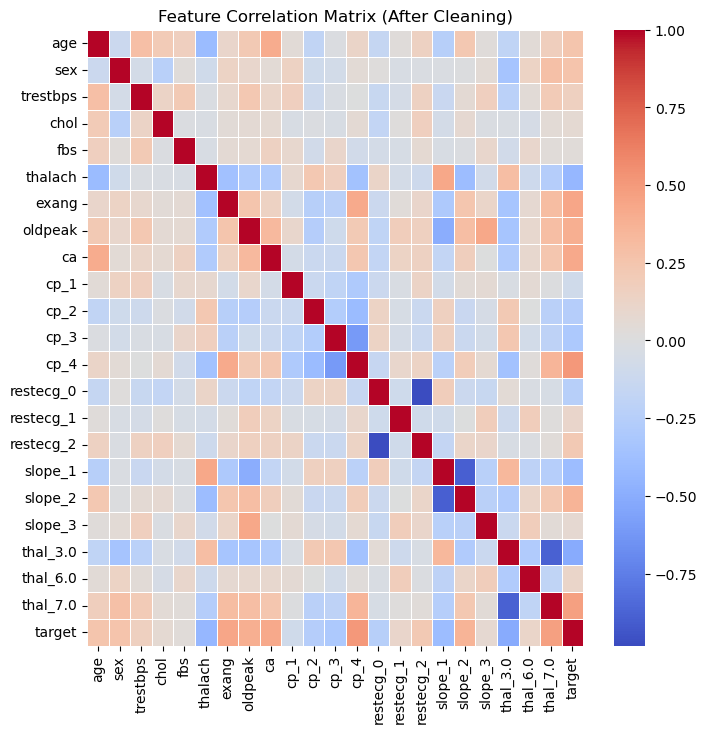

In [22]:
# combined the dataset with all clean data and target variables for Correlation matrix
fdf = pd.concat([fX_train, pd.DataFrame(fy_train, index=fX_train.index, columns=['target'])], axis=1)

correlationMatrix = fdf.corr()

plt.figure(figsize=(8, 8))
sns.heatmap(correlationMatrix, cmap='coolwarm', linewidths=0.5)
plt.title('Feature Correlation Matrix (After Cleaning)')
plt.show()

# Models 
I have trained the following Models: SVC, Hyperparameter tunning via grid search on C and gamma , Logistic Regression.

Using muti-model, L2 Regularization and Cross-Validation with 5 fold.


In [ ]:
# SVC model
model = SVC(kernel = 'rbf', random_state = 137, probability = True)
model.fit(fX_train, fy_train)

y_pred = model.predict(fX_test)

accuracy = accuracy_score(fy_test, y_pred)
print(f"Accuracy Score: {accuracy:.4f}")
cm = confusion_matrix(fy_test, y_pred)
print(classification_report(fy_test, y_pred))

Accuracy Score: 0.8816
              precision    recall  f1-score   support

           0       0.88      0.90      0.89        41
           1       0.88      0.86      0.87        35

    accuracy                           0.88        76
   macro avg       0.88      0.88      0.88        76
weighted avg       0.88      0.88      0.88        76



# Results and Analysis
### -Plots

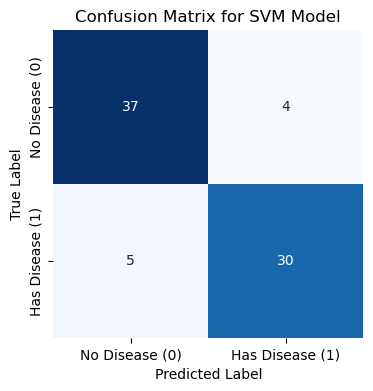

In [ ]:
# Confusion Matrix for SVM Model
class_names = ['No Disease (0)', 'Has Disease (1)']

fig, ax = plt.subplots(figsize=(4, 4))

sns.heatmap(
    cm, 
    annot=True, 
    fmt='d', 
    cmap='Blues', 
    cbar=False,
    xticklabels=class_names, 
    yticklabels=class_names
)

plt.title('Confusion Matrix for SVM Model')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [ ]:
# parameters for C and gamma to be use by GridSearchCV
param_grid = {'C': [2**i for i in range(-8, 8)], 'gamma': [2**i for i in range(-8, 8)], 'kernel': ['rbf']} 

#apply grid search
grid = GridSearchCV(SVC(random_state = 137, probability = True), param_grid, cv = 7, scoring='accuracy',refit=True) 
grid.fit(fX_train, fy_train)
print(f"Best parameters found: {grid.best_params_}")
print(f"Best cross-validation accuracy: {grid.best_score_:.4f}")
bestModel = grid.best_estimator_

Best parameters found: {'C': 0.5, 'gamma': 0.125, 'kernel': 'rbf'}
Best cross-validation accuracy: 0.8325


Best SVC
              precision    recall  f1-score   support

           0       0.88      0.88      0.88        41
           1       0.86      0.86      0.86        35

    accuracy                           0.87        76
   macro avg       0.87      0.87      0.87        76
weighted avg       0.87      0.87      0.87        76

LogisticRegression
              precision    recall  f1-score   support

           0       0.85      0.85      0.85        41
           1       0.83      0.83      0.83        35

    accuracy                           0.84        76
   macro avg       0.84      0.84      0.84        76
weighted avg       0.84      0.84      0.84        76



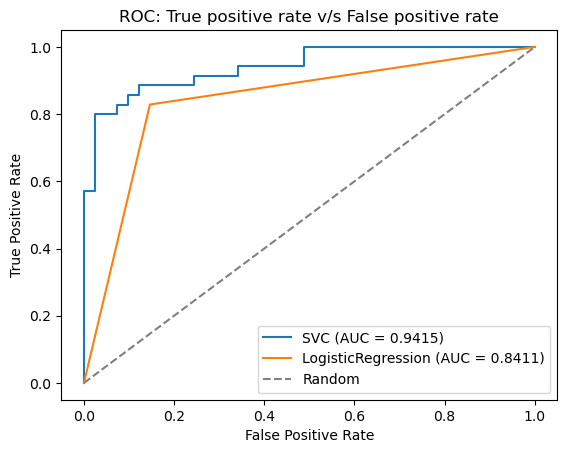

In [ ]:
# this is the best model from the SVC grid search
y_pred_proba = bestModel.predict_proba(fX_test)[:, 1]
y_pred = bestModel.predict(fX_test)
print('Best SVC')
print(classification_report(fy_test, y_pred))
fpr, tpr, thresholds = roc_curve(fy_test, y_pred_proba)
bestModel_auc = auc(fpr, tpr)

# This is the Logistic Regression Model 
logRegModel = LogisticRegression(solver='liblinear', random_state=137)
logRegModel.fit(fX_train,fy_train)

logReg_y_pred = logRegModel.predict(fX_test)
logReg_y_proba = logRegModel.predict_proba(fX_test)[:, 1]
print('LogisticRegression')
print(classification_report(fy_test, logReg_y_pred))

logReg_accuracy = accuracy_score(fy_test, logReg_y_pred)
LogReg_fpr, LogReg_tpr, thresholds = roc_curve(fy_test, logReg_y_pred)
logReg_auc = auc(LogReg_fpr, LogReg_tpr)

# plots of ROC with both models and their AUC
plt.plot(fpr, tpr, label = f'SVC (AUC = {bestModel_auc:.4f})')
plt.plot(LogReg_fpr, LogReg_tpr, label = f'LogisticRegression (AUC = {logReg_auc:.4f})')
plt.plot([0,1],[0,1], linestyle = '--', color='grey', label = 'Random')
plt.title('ROC: True positive rate v/s False positive rate')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend()
plt.show()

| Model | Test Accuracy | F1-Score (Has Disease) | Recall (Has Disease) | AUC |
| :--- | :--- | :--- | :--- | :--- |
| **Logistic Regression** | 0.84 | 0.83 | 0.83 | 0.8411
| **Optimized SVC** | 0.87 | 0.86 | 0.86 | 0.9415

We can see that SVC is a better ML model for this dataset by comparing AUC from the ROC curve, suggesting this datasets nolinearality.

With this imbalanced dataset we use F1-score metric to comfirm that SVC is still the better ML model by correctly identifying 86% of Heart Disease cases.  



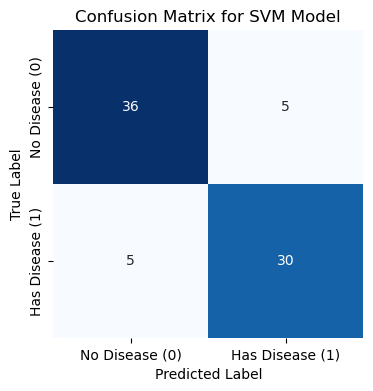

In [ ]:
# Confusion Matrix for best SVC Model
cm = confusion_matrix(fy_test, y_pred)

class_names = ['No Disease (0)', 'Has Disease (1)']

fig, ax = plt.subplots(figsize=(4, 4))

sns.heatmap(
    cm, 
    annot=True, 
    fmt='d', 
    cmap='Blues', 
    cbar=False,
    xticklabels=class_names, 
    yticklabels=class_names
)

plt.title('Confusion Matrix for SVM Model')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Discussion and Conclusion
From the Confusion Matrix above we can see that the off diagonal are both 5, this model will still misclassify a few cases.

The first SVC model is slightly better than the grid search model, maybe a better range of C and gamma to have a broader search as I didn't have much success in the search.

This model can be improved further: we could attempt to target the False Negatives as this is the more importnat misclassifed case.

We can look into different models that can improve this classification problem.